# Comparison of real HPL executions, fixed matrix size

In [1]:
import io
import zipfile
import pandas
import yaml
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    result = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    result['index'] = range(len(result))
    result['jobid'] = get_yaml(archive_name, 'info.yaml')['jobid']
    result['filename'] = archive_name
    return result

def read_result(name):
    result = read_csv(name, 'results.csv')
    temperatures = read_csv(name, 'temperatures.csv')
    info = get_yaml(name, 'info.yaml')
    hostname = [k for k in info if k.endswith('grid5000.fr')]
    assert len(hostname) == 1
    hostname = hostname[0][:-21]
    result['hostname'] = hostname
    temperatures['hostname'] = hostname
    result['start_timestamp'] = pandas.to_datetime(result['start_timestamp'])
    result['stop_timestamp'] = pandas.to_datetime(result['stop_timestamp'])
    temperatures['timestamp'] = pandas.to_datetime(temperatures['timestamp'])
    first_time = min(result.start_timestamp.min(), temperatures.timestamp.min())
    result['start_timestamp'] -= first_time
    result['stop_timestamp'] -= first_time
    temperatures['timestamp'] -= first_time
    return result, temperatures

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

directory = 'performance_evolution/'
results = [read_result(directory + filename) for filename in os.listdir(directory)]

df = pandas.concat([t[0] for t in results])
temperatures = pandas.concat([t[1] for t in results])
df.head()

,bcast,block_size,depth,filename,gflops,hostname,index,jobid,matrix_size,mem_align,...,proc_p,proc_q,process_per_node,residual,rfact,start_timestamp,stop_timestamp,swap,thread_per_process,time
0,2,128,1,performance_evolution/grenoble_2019-03-19_1856...,879.0,dahu-12,0,1856179,65536,8,...,4,8,32,0.001254,2,00:01:24.670483,00:05:07.163753,0,1,213.48
1,2,128,1,performance_evolution/grenoble_2019-03-19_1856...,881.0,dahu-12,1,1856179,65536,8,...,4,8,32,0.001254,2,00:05:07.262410,00:08:49.339635,0,1,213.00
2,2,128,1,performance_evolution/grenoble_2019-03-19_1856...,881.5,dahu-12,2,1856179,65536,8,...,4,8,32,0.001254,2,00:08:49.446410,00:12:30.969962,0,1,212.88
3,2,128,1,performance_evolution/grenoble_2019-03-19_1856...,879.9,dahu-12,3,1856179,65536,8,...,4,8,32,0.001254,2,00:12:31.070417,00:16:13.296396,0,1,213.27
4,2,128,1,performance_evolution/grenoble_2019-03-19_1856...,882.2,dahu-12,4,1856179,65536,8,...,4,8,32,0.001254,2,00:16:13.398566,00:19:54.689687,0,1,212.71


### Checking the parameters

In [2]:
name_exceptions = {'time', 'gflops', 'residual', 'matrix_size', 'mode', 'index', 'start_timestamp', 'stop_timestamp', 'jobid', 'filename', 'hostname'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,swap,bcast,depth,rfact,thread_per_process,proc_q,block_size,mem_align,pfact,proc_p,process_per_node
0,0,2,1,2,1,8,128,8,1,4,32


### Comparing the executions

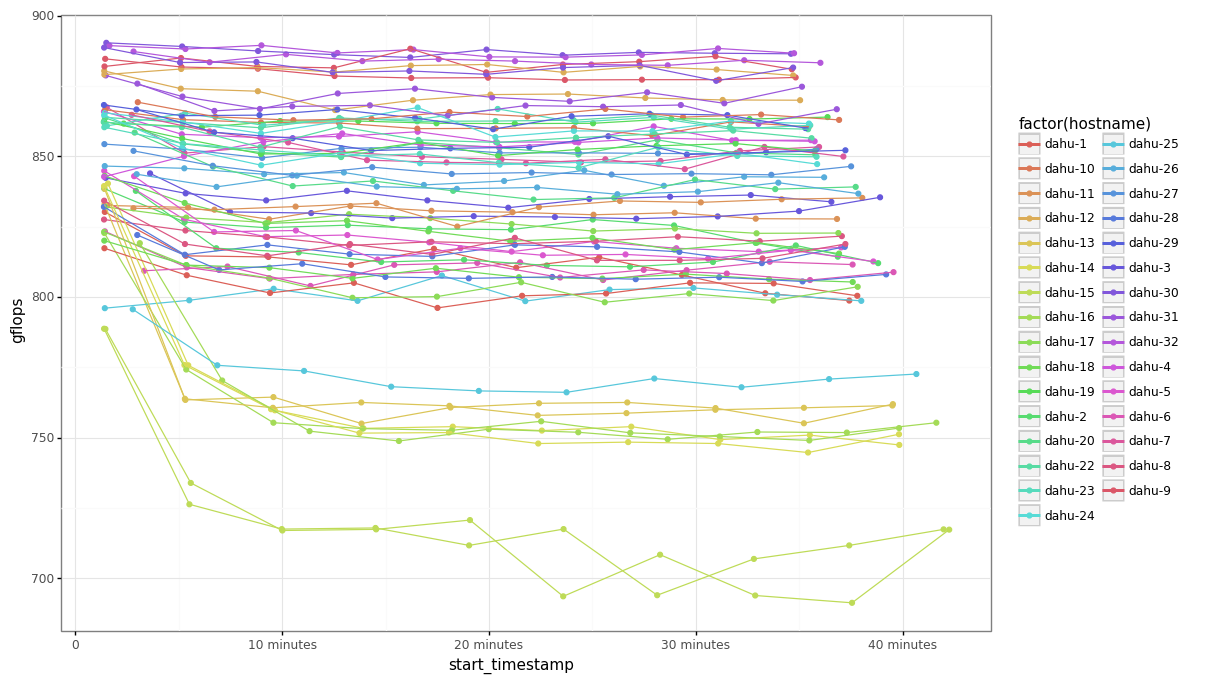

<ggplot: (-9223363271282188284)>

In [3]:
plot = ggplot(df, aes(x='start_timestamp', y='gflops', color='factor(hostname)', group='jobid')) + geom_point() + geom_line() + theme_bw()
plot

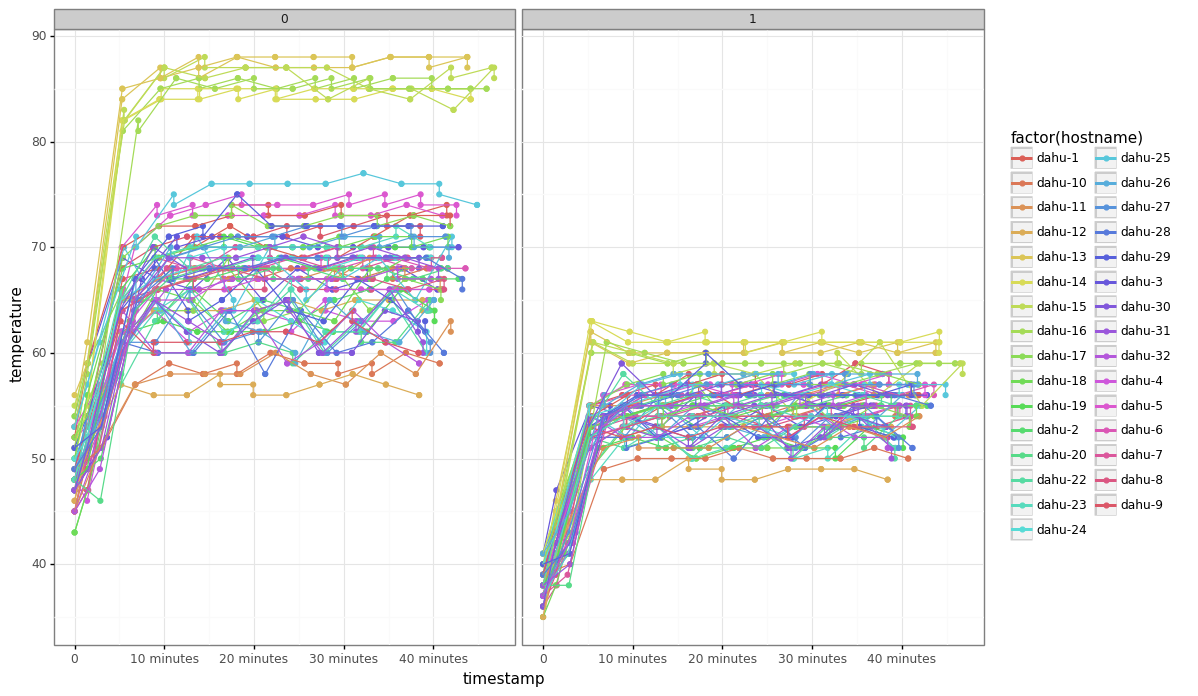

<ggplot: (8765546048790)>

In [4]:
plot = ggplot(temperatures, aes(x='timestamp', y='temperature', color='factor(hostname)', group='jobid')) + geom_point() + geom_line() + theme_bw() + facet_wrap('sensor_id')
plot

In [5]:
list(sorted(df[df['gflops'] < 775].hostname.unique()))

['dahu-13', 'dahu-14', 'dahu-15', 'dahu-16', 'dahu-25']